In [39]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pyhive import presto
from pymongo import MongoClient
import warnings
warnings.filterwarnings("ignore")

presto_conn = presto.connect(
    host='presto.processing.yoda.run',
    port=80,
    protocol='http',
    catalog='hive',
    username='mayank.jha@rapido.bike',
    # requests_kwargs=req_kw,
)

In [18]:
start_date = '2021-01-04'
end_date = '2021-01-31'
#city = 'Delhi'

In [19]:
# Fetch captains who registered in a particular time period

def get_registered_captains(start_date, end_date):
    orders_query = """   select captainid, 
        registrationdate,
        week_of_year(registrationdate) as registration_week
        --lifetimerides, 
        --lastridedate, 
        --avgridesperday, 
        --avgcaptainrating, 
        --order_earning, 
        --incentive_earning, 
        --penalty, 
        --preferredtimebucket 
    
    from datasets.captain_single_view 
    where activationdate is not null 
        and date_format(registrationdate, '%Y%m%d') between '{sd}' and '{ed}'            
               """.format(sd = start_date.replace('-',''), ed = end_date.replace('-',''))


    df_lh = pd.read_sql(orders_query, presto_conn)
    
    print(" fetched LTR : ", len(df_lh))

    return df_lh

 
df_registered_captains = get_registered_captains(start_date, end_date)

df_registered_captains.head()

 fetched LTR :  50246


,captainid,registrationdate,registration_week
0,5ff2a32b31243a24e8b04c19,2021-01-04,1
1,5ffad58a857d1b30a6285c6c,2021-01-10,1
2,5ff308c731243a49fbb091aa,2021-01-04,1
3,5ff9a43187d741134821c45f,2021-01-09,1
4,5ca033ac8c352421ea044b6d,2021-01-17,2


In [20]:
start_date = '2021-01-04'
end_date = '2021-04-25'

In [21]:
# Rides & Ratings

rides_query = """SELECT distinct rider,
                    orderdate
                    
                    from legacy.orders
                    where orderdate >= '{sd}'
                    and orderdate <= '{ed}'
                    and status = 'dropped'
                    and spdfraud_flag != 1
                    
                    """.format(sd=start_date, ed= end_date)

df_rides = pd.read_sql(rides_query, presto_conn)
df_rides.head()

,rider,orderdate
0,59c6160657b98b565cdde42f,2021-04-22
1,5e19ce36e556205f524c33e8,2021-04-22
2,60222869c3fe0856576d13e7,2021-04-22
3,5e5dc3db3655eacf081228b7,2021-04-22
4,5de11af2ac56a62ec5e13d86,2021-04-22


In [22]:
df_captains = df_registered_captains.merge(df_rides, how = 'left', left_on = 'captainid', right_on = 'rider')
df_captains.head()

,captainid,registrationdate,registration_week,rider,orderdate
0,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-01-29
1,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-03-14
2,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-02-14
3,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-01-26
4,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-01-12


In [23]:
df_captains['days_since_inactive'] = df_captains['last_ride_date'].apply(lambda x : (pd.to_datetime('2021-05-01')-pd.to_datetime(x)).days)
df_captains.head()

,captainid,registrationdate,week,rider,last_ride_date,last_ride_week,days_since_inactive
0,5ff4a7ee31243a9564b15832,2021-01-05,1,5ff4a7ee31243a9564b15832,2021-02-08,6.0,82.0
1,5e13945b715b3f22b9691985,2021-01-29,4,5e13945b715b3f22b9691985,2021-04-30,17.0,1.0
2,5fd97da308e6155a61ca69dd,2021-01-28,4,5fd97da308e6155a61ca69dd,2021-02-15,7.0,75.0
3,5ff1424c4319a7f244bb236a,2021-01-03,53,5ff1424c4319a7f244bb236a,2021-03-22,12.0,40.0
4,600548e5e6c0de4eaaf650f4,2021-01-18,3,NaN,NaN,NaN,NaN


In [25]:
start_date = '2021-05-01'
end_date = '2021-07-31'

In [27]:
# Rides & Ratings

rides_query = """SELECT rider as rider_2,
                    min(orderdate) as last_ride_date_2,
                    min(week_of_year(date(orderdate))) as last_ride_week_2
                    
                    from legacy.orders
                    where orderdate >= '{sd}'
                    and orderdate <= '{ed}'
                    and status = 'dropped'
                    and spdfraud_flag != 1
                    
                    group by 1""".format(sd=start_date, ed= end_date)

df_rides2 = pd.read_sql(rides_query, presto_conn)
df_rides2.head()

,rider_2,last_ride_date_2,last_ride_week_2
0,60e81056569b264dfe7437c8,2021-07-14,28
1,5d847fbd486b0b21476f97e8,2021-05-03,18
2,5f512c6f81724784009f7982,2021-07-07,27
3,5d1217d7d6cbfc6a9db2aa4e,2021-07-11,27
4,5c746bb4343a5357615e3397,2021-06-26,25


In [29]:
df_captains = df_captains.merge(df_rides2, how = 'left', left_on = 'captainid', right_on = 'rider_2')
df_captains.head()

,captainid,registrationdate,week,rider,last_ride_date,last_ride_week,days_since_inactive,rider_2,last_ride_date_2,last_ride_week_2
0,5ff4a7ee31243a9564b15832,2021-01-05,1,5ff4a7ee31243a9564b15832,2021-02-08,6.0,82.0,NaN,NaN,NaN
1,5e13945b715b3f22b9691985,2021-01-29,4,5e13945b715b3f22b9691985,2021-04-30,17.0,1.0,5e13945b715b3f22b9691985,2021-05-01,17.0
2,5fd97da308e6155a61ca69dd,2021-01-28,4,5fd97da308e6155a61ca69dd,2021-02-15,7.0,75.0,NaN,NaN,NaN
3,5ff1424c4319a7f244bb236a,2021-01-03,53,5ff1424c4319a7f244bb236a,2021-03-22,12.0,40.0,5ff1424c4319a7f244bb236a,2021-05-25,21.0
4,600548e5e6c0de4eaaf650f4,2021-01-18,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_captains['days_since_inactive_2'] = df_captains.apply(lambda x : (pd.to_datetime(x['last_ride_date_2'])-pd.to_datetime(x['last_ride_date'])).days, axis = 1)
df_captains['retention'] = df_captains['last_ride_date_2'].apply(lambda x : 0 if pd.isna(x) else 1)
df_captains.head()

,captainid,registrationdate,week,rider,last_ride_date,last_ride_week,days_since_inactive,rider_2,last_ride_date_2,last_ride_week_2,days_since_inactive_2,retention
0,5ff4a7ee31243a9564b15832,2021-01-05,1,5ff4a7ee31243a9564b15832,2021-02-08,6.0,82.0,NaN,NaN,NaN,NaN,0
1,5e13945b715b3f22b9691985,2021-01-29,4,5e13945b715b3f22b9691985,2021-04-30,17.0,1.0,5e13945b715b3f22b9691985,2021-05-01,17.0,1.0,1
2,5fd97da308e6155a61ca69dd,2021-01-28,4,5fd97da308e6155a61ca69dd,2021-02-15,7.0,75.0,NaN,NaN,NaN,NaN,0
3,5ff1424c4319a7f244bb236a,2021-01-03,53,5ff1424c4319a7f244bb236a,2021-03-22,12.0,40.0,5ff1424c4319a7f244bb236a,2021-05-25,21.0,64.0,1
4,600548e5e6c0de4eaaf650f4,2021-01-18,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [33]:
df_captains.to_csv('x.csv', index=False)

In [32]:
df_temp = df_captains.copy()
df_temp = df_temp[df_temp['last_ride_date'].notna()]

In [ ]:
plt.hist(df_temp['days_since_inactive'], bins = range(df_reinstalled['day_diff'].min(),df_reinstalled['day_diff'].max()+1))
plt.show()

In [23]:
df_captains['day_diff'] = df_captains.apply(lambda x : (pd.to_datetime(x['orderdate'])-pd.to_datetime(x['registrationdate'])).days, axis=1)
df_captains['week_diff'] = df_captains['day_diff'].apply(lambda x : x//7 if x%7==0 else x//7+1)
df_captains.head()

In [24]:
df_captains.to_csv('nth_day_retention_data.csv', index=False)
df_captains.head()

,captainid,registrationdate,registration_week,rider,orderdate,day_diff,week_diff
0,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-01-29,25.0,4.0
1,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-03-14,69.0,10.0
2,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-02-14,41.0,6.0
3,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-01-26,22.0,4.0
4,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-01-12,8.0,2.0


In [40]:
df_captains = pd.read_csv('nth_day_retention_data.csv')
df_captains.head()

,captainid,registrationdate,registration_week,rider,orderdate,day_diff,week_diff
0,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-01-29,25.0,4.0
1,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-03-14,69.0,10.0
2,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-02-14,41.0,6.0
3,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-01-26,22.0,4.0
4,5ff2a32b31243a24e8b04c19,2021-01-04,1,5ff2a32b31243a24e8b04c19,2021-01-12,8.0,2.0


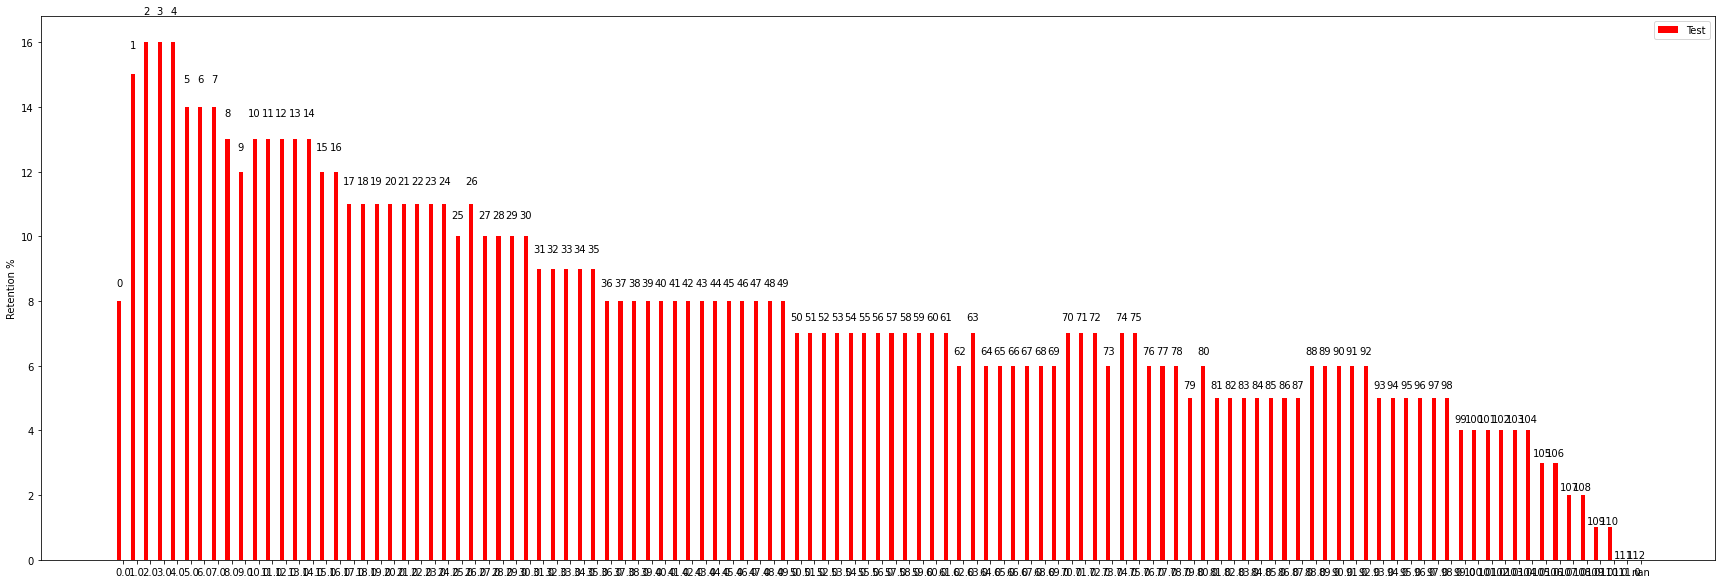

In [50]:
df_temp = df_captains[df_captains['registration_week']==1]
y = []
for day in np.sort(df_temp['day_diff'].unique()):
    y.append(round(df_temp[df_temp['day_diff']==day]['rider'].nunique()/df_temp['captainid'].nunique()*100,0))

N = df_temp['day_diff'].nunique()+1
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, y, width, color='r', label = 'Test')


ax.set_xticklabels(np.sort(df_temp['day_diff'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Retention %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(rect.get_x()+1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

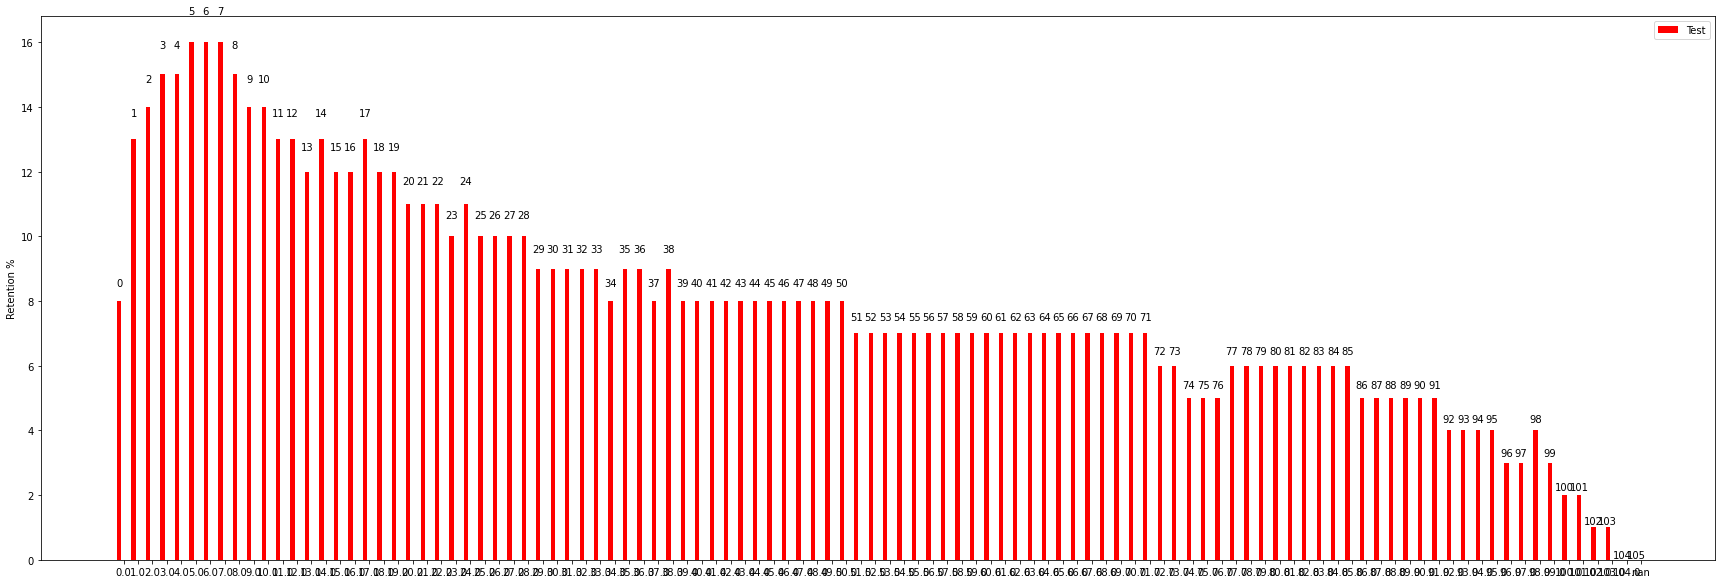

In [107]:
df_temp = df_captains[df_captains['registration_week']==2]
y = []
for day in np.sort(df_temp['day_diff'].unique()):
    y.append(round(df_temp[df_temp['day_diff']==day]['rider'].nunique()/df_temp['captainid'].nunique()*100,0))

N = df_temp['day_diff'].nunique()+1
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, y, width, color='r', label = 'Test')


ax.set_xticklabels(np.sort(df_temp['day_diff'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Retention %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(rect.get_x()+1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

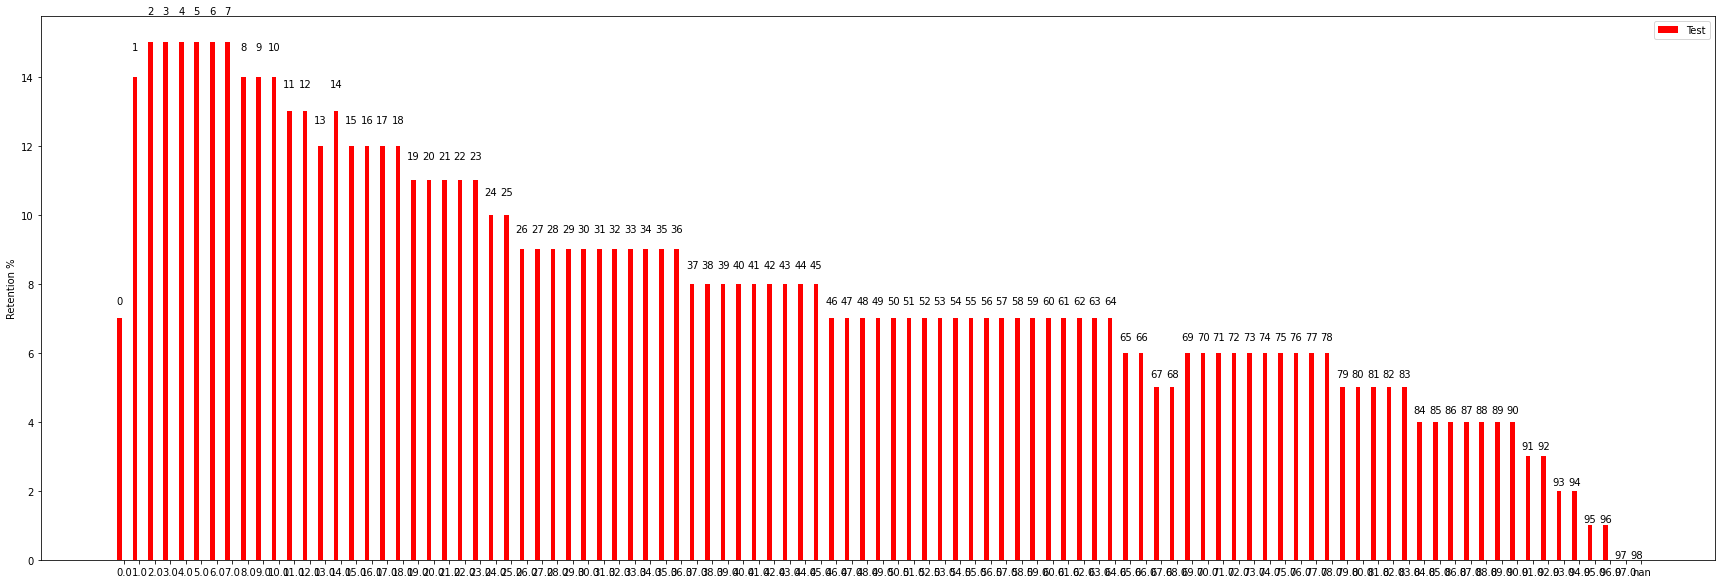

In [108]:
df_temp = df_captains[df_captains['registration_week']==3]
y = []
for day in np.sort(df_temp['day_diff'].unique()):
    y.append(round(df_temp[df_temp['day_diff']==day]['rider'].nunique()/df_temp['captainid'].nunique()*100,0))

N = df_temp['day_diff'].nunique()+1
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, y, width, color='r', label = 'Test')


ax.set_xticklabels(np.sort(df_temp['day_diff'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Retention %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(rect.get_x()+1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

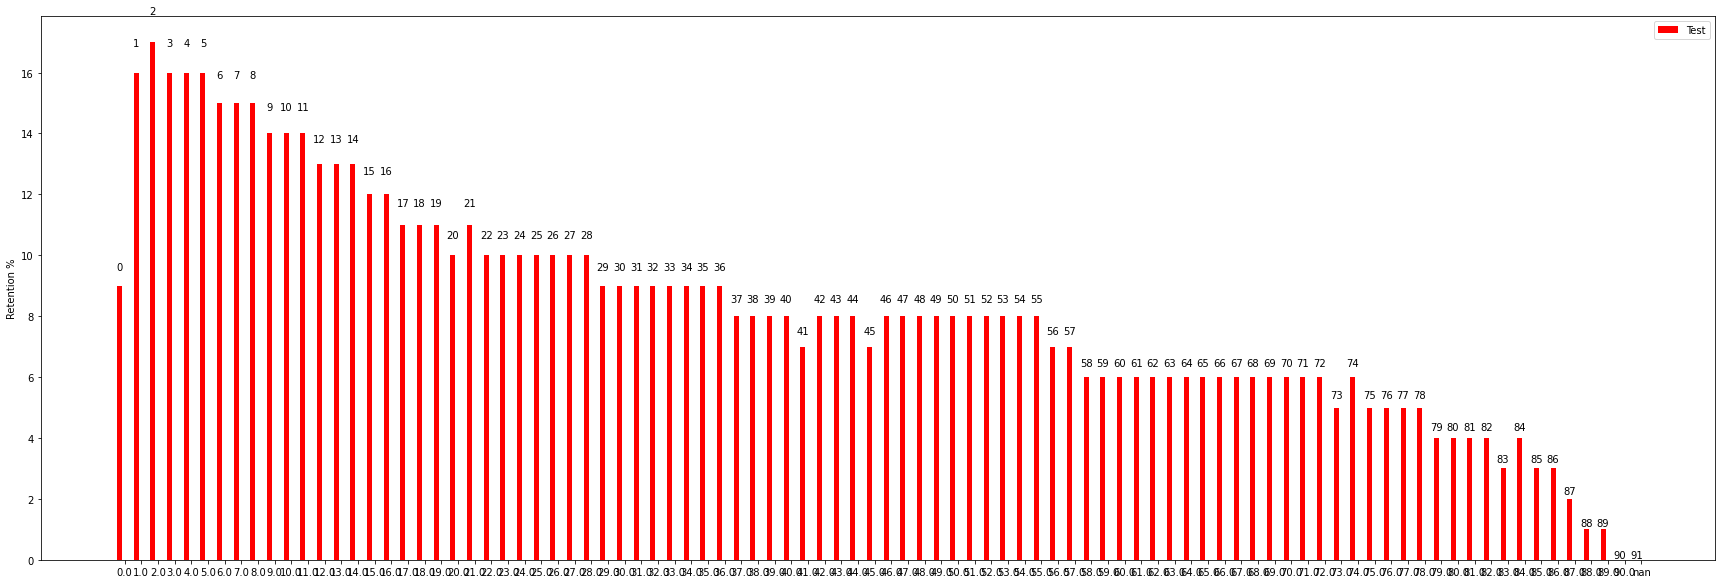

In [109]:
df_temp = df_captains[df_captains['registration_week']==4]
y = []
for day in np.sort(df_temp['day_diff'].unique()):
    y.append(round(df_temp[df_temp['day_diff']==day]['rider'].nunique()/df_temp['captainid'].nunique()*100,0))

N = df_temp['day_diff'].nunique()+1
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, y, width, color='r', label = 'Test')


ax.set_xticklabels(np.sort(df_temp['day_diff'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Retention %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(rect.get_x()+1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

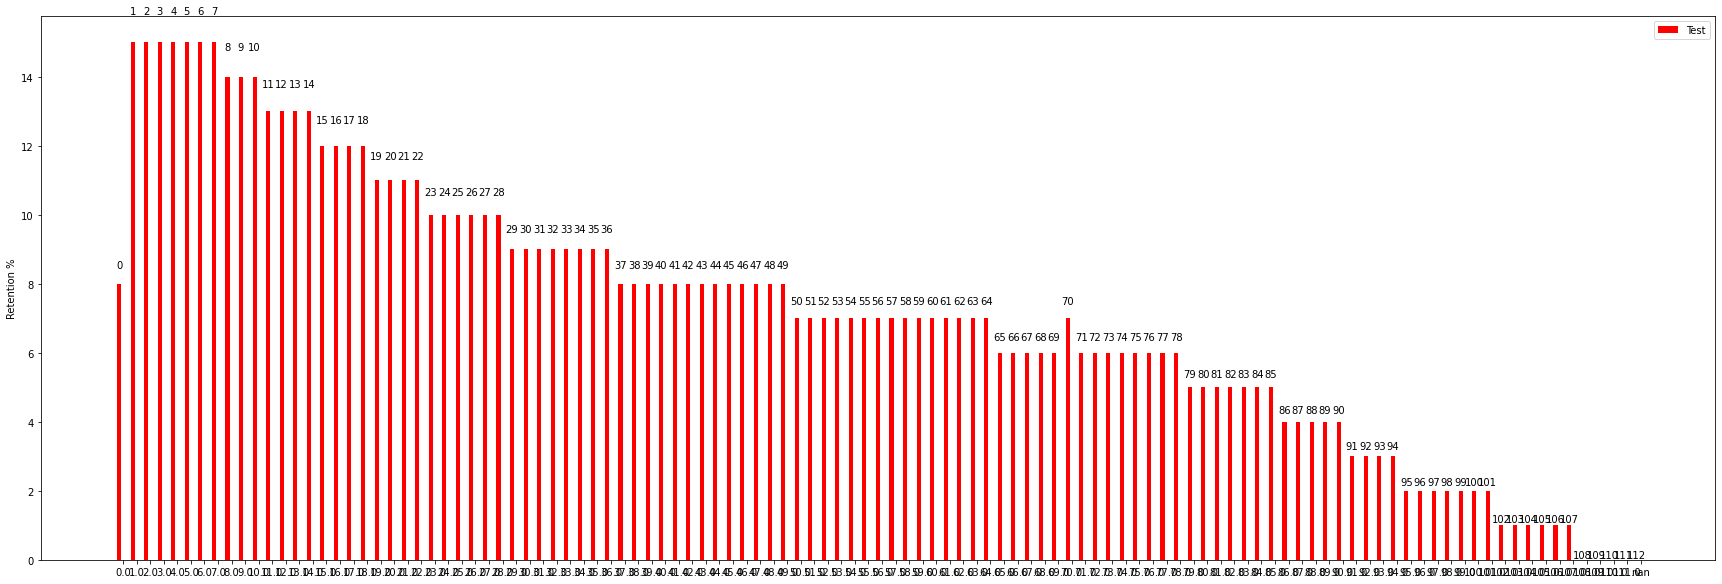

In [110]:
df_temp = df_captains.copy()
y = []
for day in np.sort(df_temp['day_diff'].unique()):
    y.append(round(df_temp[df_temp['day_diff']==day]['rider'].nunique()/df_temp['captainid'].nunique()*100,0))

N = df_temp['day_diff'].nunique()+1
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, y, width, color='r', label = 'Test')


ax.set_xticklabels(np.sort(df_temp['day_diff'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Retention %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(rect.get_x()+1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

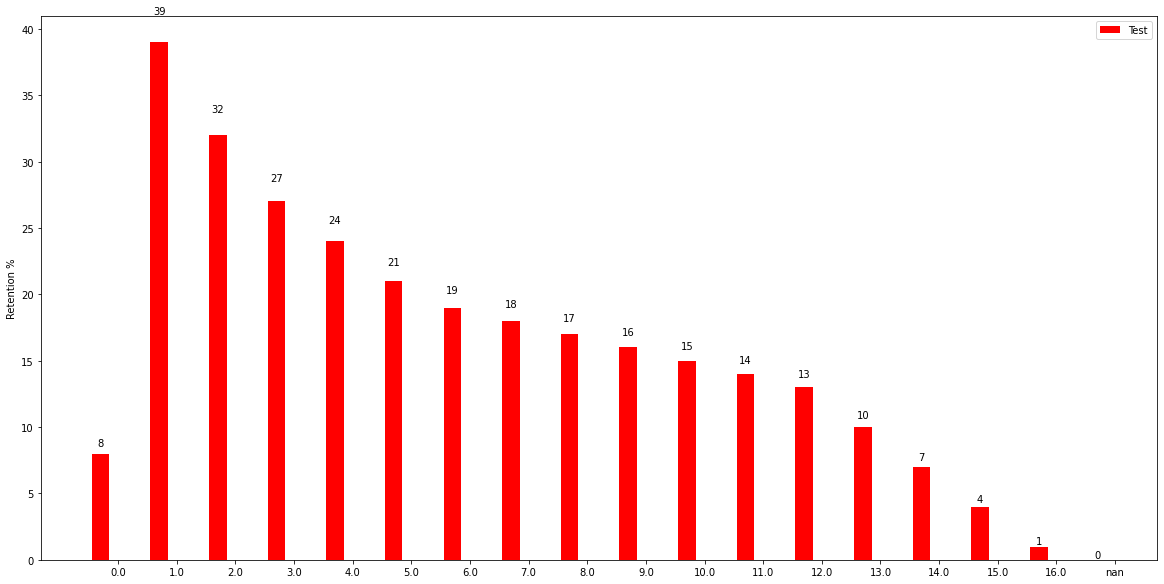

In [111]:
df_temp = df_captains.copy()
y = []
for day in np.sort(df_temp['week_diff'].unique()):
    y.append(round(df_temp[df_temp['week_diff']==day]['rider'].nunique()/df_temp['captainid'].nunique()*100,0))

N = df_temp['week_diff'].nunique()+1
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, y, width, color='r', label = 'Test')


ax.set_xticklabels(np.sort(df_temp['week_diff'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Retention %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

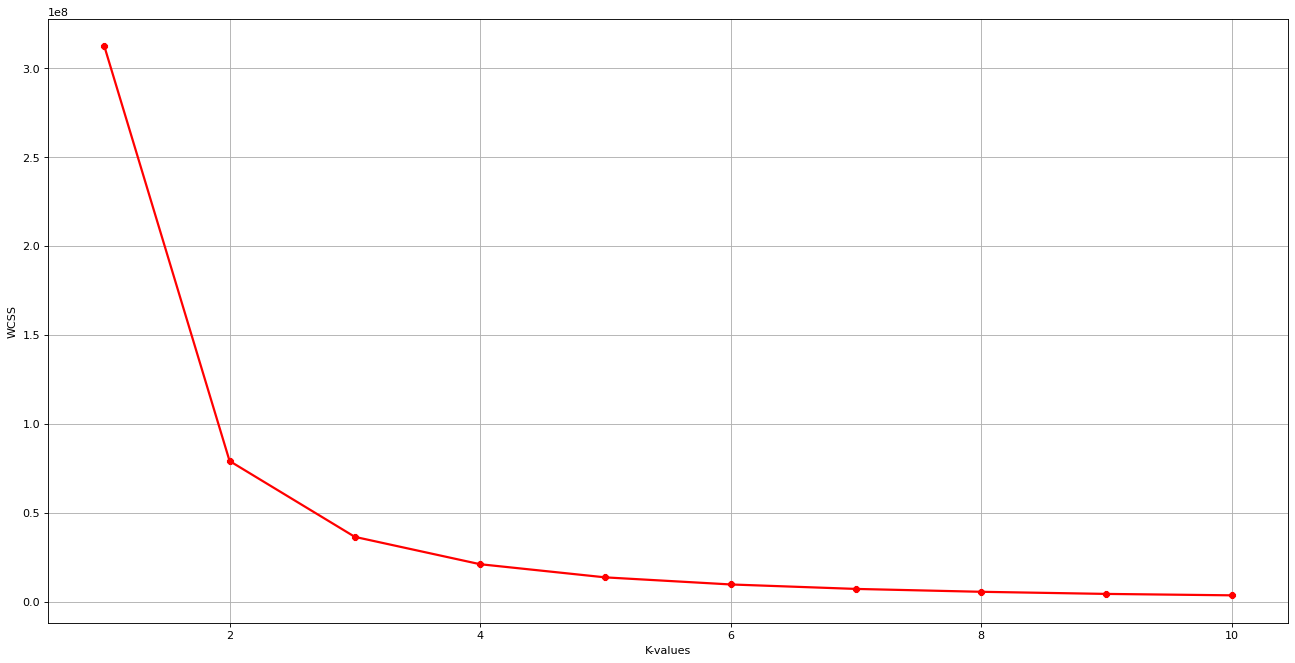

In [28]:
df_temp = df_captains[df_captains['day_diff'].notna()]
X5=df_temp.loc[:,['day_diff']].values
from sklearn.cluster import KMeans
wcss=[]
for k in range (1,11):
    kmeans=KMeans(n_clusters=k,init="k-means++")
    kmeans.fit(X5)
    wcss.append(kmeans.inertia_)
fig = plt.figure(figsize=(20, 10), dpi=80)
plt.grid()
plt.plot(range(1,11),wcss,linewidth=2,color="red",marker="8")
plt.xlabel("K-values")
plt.ylabel("WCSS")
plt.show()

In [37]:
centroids = kmeans1.cluster_centers_
print(centroids)

[[32.79915596]
 [83.9707307 ]
 [10.02940605]
 [57.53360781]]


In [36]:
kmeans1=KMeans(n_clusters=4)
labels=kmeans1.fit_predict(X5)
print(labels)

[0 3 0 ... 3 3 2]


In [42]:
df_captains[(df_captains['orderdate'] >= '2021-02-01') & (df_captains['orderdate'] <= '2021-02-28')]['captainid'].nunique()/df_captains['captainid'].nunique()*100

39.3086016797357

In [43]:
df_captains[(df_captains['orderdate'] >= '2021-03-01') & (df_captains['orderdate'] <= '2021-03-28')]['captainid'].nunique()/df_captains['captainid'].nunique()*100

26.96334036540222

In [44]:
df_captains[(df_captains['orderdate'] >= '2021-03-29') & (df_captains['orderdate'] <= '2021-04-25')]['captainid'].nunique()/df_captains['captainid'].nunique()*100

20.566811288460773

In [47]:
# week 1
den = df_captains[(df_captains['registrationdate'] >= '2021-01-04') & (df_captains['registrationdate'] <= '2021-01-10')]['captainid'].nunique()
num = df_captains[(df_captains['orderdate'] >= '2021-01-11') & (df_captains['orderdate'] <= '2021-01-17') & (df_captains['registrationdate'] >= '2021-01-04') & (df_captains['registrationdate'] <= '2021-01-10')]['captainid'].nunique()
ret = num/den*100
print(ret)

34.18485141878305


In [48]:
# week 2
den = df_captains[(df_captains['registrationdate'] >= '2021-01-04') & (df_captains['registrationdate'] <= '2021-01-10')]['captainid'].nunique()
num = df_captains[(df_captains['orderdate'] >= '2021-01-18') & (df_captains['orderdate'] <= '2021-01-24') & (df_captains['registrationdate'] >= '2021-01-04') & (df_captains['registrationdate'] <= '2021-01-10')]['captainid'].nunique()
ret = num/den*100
print(ret)

30.297162433901843


In [49]:
# week 3
den = df_captains[(df_captains['registrationdate'] >= '2021-01-04') & (df_captains['registrationdate'] <= '2021-01-10')]['captainid'].nunique()
num = df_captains[(df_captains['orderdate'] >= '2021-01-25') & (df_captains['orderdate'] <= '2021-01-31') & (df_captains['registrationdate'] >= '2021-01-04') & (df_captains['registrationdate'] <= '2021-01-10')]['captainid'].nunique()
ret = num/den*100
print(ret)

25.984955686303717
